In [1]:
import numpy as np
import h5py
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

Define basic data augmentation functions

In [ ]:
# Adds Gaussian noise to the input array with specified standard deviation
def add_noise(x, std=0.01):
    noise = np.random.normal(0, std, x.shape)
    return x + noise

# Flips the input array along the channel axis (second-to-last axis) - not sure if helpful
def channel_flip(x):
    return np.flip(x, axis=-2)

# Shifts the input array along the channel axis by a random amount within the given range
def spatial_shift(x, shift_range=20):
    shift = np.random.randint(-shift_range, shift_range)
    return np.roll(x, shift, axis=-2)

# Crops the input array along the time axis to a random segment of the specified size
def time_crop(x, crop_size):
    if x.shape[-1] <= crop_size:
        return x
    start = np.random.randint(0, x.shape[-1] - crop_size)
    return x[..., start:start+crop_size]


Testing data augmentation methods

/tmp/ipykernel_1184580/350968604.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1184580/350968604.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


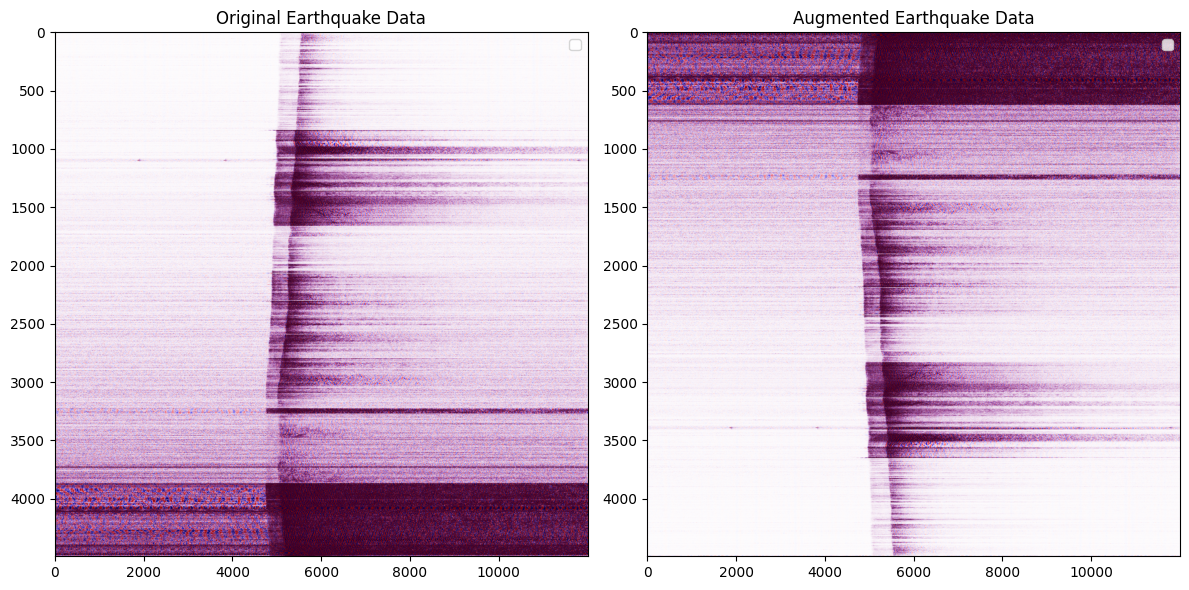

In [ ]:
# Load earthquake data from the HDF5 file (adjust the file path as needed)
file_path = "/1-fnp/petasaur/p-jbod1/rainier/2023/08/27/decimator_2023-08-27_10.10.00_UTC.h5" # medium earthquake event
with h5py.File(file_path, 'r', locking=False) as f:
    earthquake_data = f['Acquisition/Raw[0]/RawData'][:]

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply highpass filter to the data
fs = 200  # Sampling frequency (Hz)
cutoff = 1  # Cutoff frequency (Hz)
filtered_data = highpass_filter(earthquake_data, cutoff, fs)
filtered_data_max = np.percentile(np.abs(filtered_data), 90)

# Apply the augmentation
augmented_data = add_noise(filtered_data, std=0.1)
# augmented_data = channel_flip(filtered_data)
# augmented_data = spatial_shift(filtered_data, shift_range=100)
# augmented_data = time_crop(filtered_data, crop_size=1000)


augmented_data_max = np.percentile(np.abs(augmented_data), 90)

# Plot the original and augmented data for comparison
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(1, 2, 1)
plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-filtered_data_max, vmax=filtered_data_max)
plt.title('Original Earthquake Data')
plt.legend()

# Plot augmented data
plt.subplot(1, 2, 2)
plt.imshow(augmented_data.T, aspect='auto', cmap='seismic', vmin=-augmented_data_max, vmax=augmented_data_max)
plt.title('Augmented Earthquake Data')
plt.legend()

plt.tight_layout()
plt.show()